# **AIML CA2 Assignment - Part A (Clustering)**
**Name**: JEROME LOKE  
**Student ID**: P2510707  
**Class**: DAAA/FT/1B/01  

---


Conclusion should include  
• How  I  perform  customer  segmentation  using  unsupervised  machine  learning algorithm in Python?  
• (!!) What are the characteristics of each customer cluster?  
• (!!) Which group of customer needs to pay more attention to?

What to do?
1. Use  clustering  techniques  to  understand  the  data  with  the  goal  of  answering the three questions above. Use scikit-learn library to build the model.  
2. In the Jupyter notebook, write your report detailing your implementation, your experiments and analysis (along with your Python code and comments), as well  as your answers to the questions at the end of your notebook.  
3. Include some tests of your clustering with different possible values of k.  
4. Determine the best possible value of k. And show how you can determine that this is the best value for k.  
5. Use more than just one clustering algorithm (so, not just k-means).  

6. Summarize  the  highlights  of  your  findings  in  slides.  Mention  the  machine learning process you went through, the data exploration, data cleaning, feature engineering, model building, and evaluation. Focus more on the result analysis.

Workflow:
1. EDA
2. Data Preprocessing  
3. Feature Engineering  
4. Model Clustering  
5. Model Evaluation  
6. Interpretation / Conclusion

---

### Import Libraries

In [354]:
# Data Analysis
import numpy as np
import pandas as pd

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# model training
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

---

## **STAGE 1: EDA (Exploratory Data Analysis)**
* **Preview Dataset**: Display first 5 rows to understand its structure.
* **Shape**: Dataset has X rows and Y columns.
* **Info & Summary Statistics**: Analyse data types, non-missing counts, and key statistics (mean, standard deviation, etc.) for numerical columns.
* **Investigate Irregular Data**: Use intuition to identify and resolve irregular data like negative prices or abnormally large Age values.
* **Visualise Distributions**: Perform univariate and bivariate analysis using matplotlib and seaborn to identify patterns.
* **Missing Values**: Identify missing values per column / overall.

### Load & Preview Dataset

In [355]:
df = pd.read_csv("./CA2-datasets/CA2-Customer-Data.csv")
df.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [356]:
print(f"rows: {df.shape[0]}, cols: {df.shape[1]}")

rows: 200, cols: 5


### Investigate Irregularities in Dataset

#### dtypes

In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           200 non-null    int64 
 1   Gender               200 non-null    object
 2   Age                  200 non-null    int64 
 3   Income (k$)          200 non-null    int64 
 4   How Much They Spend  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


* No necessary edits needed for column dtypes

#### Features (numerical then categorical)

In [358]:
df.describe()

,CustomerID,Age,Income (k$),How Much They Spend
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


* Mean `Age` is ~39  

* Mean `Income (k$)` is ~60.6k$  

* #### **Key Observation:** `How Much They Spend` has no labelled unit, and interestingly ranges from 1.0 to 99.0. This suggests that this feature could represent a "spending score" of 1-99 instead of raw "money spent".

In [359]:
df.describe(include='O')

,Gender
count,200
unique,2
top,Female
freq,112


* `Gender` shows an imbalance (112 Females : 88 Males), might influence our clusters later on

#### Investigate `How Much They Spend`
Intuitively, this feature would represent the amount of money spent by each customer. However, the range of this feature is only between 1 - 99, which is strange as real-world data rarely caps at 99 so cleanly.  
We will investigate the feature's distributions to see whether it represents an engineered score between 1-99 or not.  

Key Assumptions:
* Real-world money data should be right-skewed
* Richer customers should have higher input values for this feature

##### 1. Distributions of `How Much They Spend`

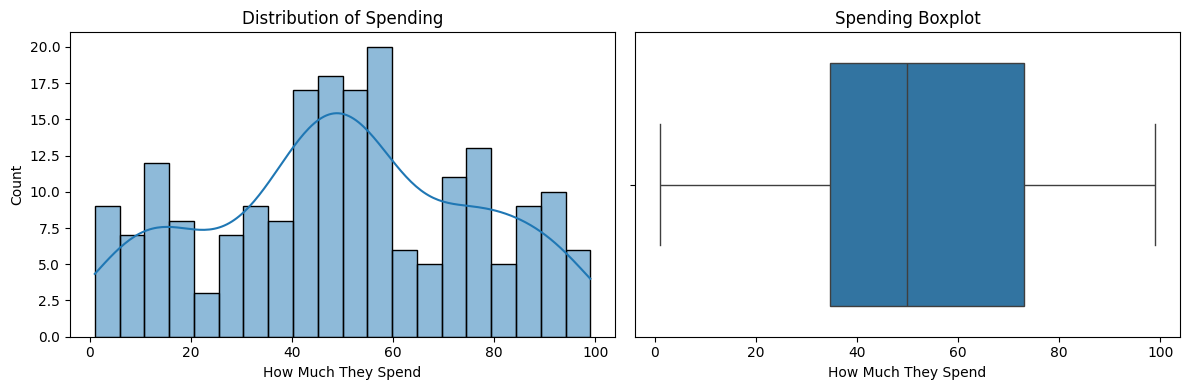

Median: 50.0
Q1: 34.75
Q3: 73.0


In [360]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# histogram
sns.histplot(df["How Much They Spend"], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Spending")
axes[0].set_xlabel("How Much They Spend")
axes[0].set_ylabel("Count")

# boxplot
sns.boxplot(x=df["How Much They Spend"], ax=axes[1])
axes[1].set_title("Spending Boxplot")
axes[1].set_xlabel("How Much They Spend")

plt.tight_layout()
plt.show()

print("Median:", df["How Much They Spend"].median())
print("Q1:", df["How Much They Spend"].quantile(0.25))
print("Q3:", df["How Much They Spend"].quantile(0.75))

* How Much They Spend displays a trimodal distribution instead of a right-skew, which supports the hypothesis that it the feature represents an engineered Spending Score of 1-99 instead of a raw spending amount.

##### 2. `Income (k$)` VS `How Much They Spend`
"Do richer people tend to spend more?"

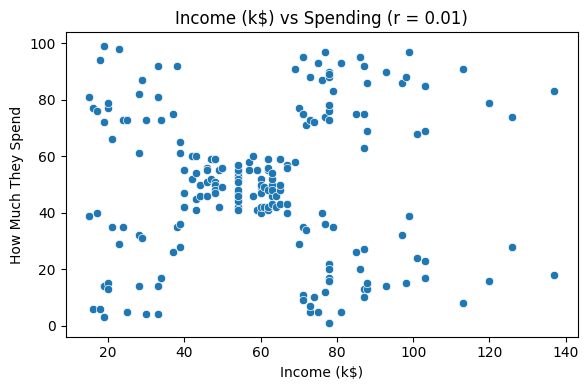

In [361]:
# calculate correlation coefficient
corr = df["Income (k$)"].corr(df["How Much They Spend"])

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="Income (k$)", y="How Much They Spend")
plt.title(f"Income (k$) vs Spending (r = {corr:.2f})")
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend")
plt.tight_layout()
plt.show()

* There is a ***weak*** positive relationship between `Income (k$)` and `How Much They Spend`, suggesting that richer people do not tend to spend more.  

* The low Pearson correlation points to the fact that these features are more suitable for customer segmentation than linear prediction. Customers were naturally separated into clusters as shown from the scatter plot. For instance, all high-earning customers (Income (k$) > 70) are separated into two groups: High spending and Low spending.

* Shows that Income (k$) and How Much They Spend separates customers meaningfully (helps distinguish customer types). The clear 'X' structure formed suggests they are strong features.

##### 3. Spending by Age Group
Split customers into five specific age ranges and compare their respective spending.  

"Do older customers tend to spend less?"

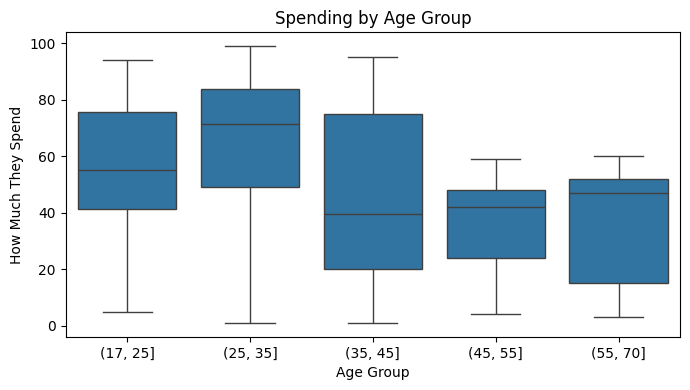

In [362]:
df["Age Group"] = pd.cut(
  df["Age"],
  bins=[17, 25, 35, 45, 55, 70]
)

plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x="Age Group", y="How Much They Spend")
plt.title("Spending by Age Group")
plt.tight_layout()
plt.show()


* Highest spending at the 26-35years age group, indicating young working adults show the highest spending potential.

* Widest variety of spending at the 36-45years age group, suggesting strong potential for growth via targeted campaigns.

* Older folks have a wider variety of spenders, with some spending way below the average (see the minimum). However, the median (Q2) spending of the 56-70years age group is actually higher than the 36-45 and 46-55 age groups, suggesting that older folks do not spend the least.

##### Conclusion: `How Much They Spend` = `Spending Score (1-99)`

In [363]:
df.rename(
  columns={'How Much They Spend': 'Spending Score (1-99)'},
  inplace=True
)
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Income (k$)', 'Spending Score (1-99)',
       'Age Group'],
      dtype='object')

#### Visualise `Age` Distribution

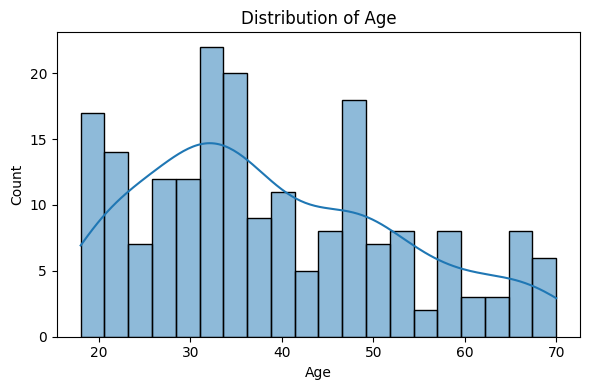

Median: 36.0
Q1: 28.75
Q3: 49.0


In [364]:
plt.figure(figsize=(6, 4))

sns.histplot(df["Age"], bins=20, kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

print("Median:", df["Age"].median())
print("Q1:", df["Age"].quantile(0.25))
print("Q3:", df["Age"].quantile(0.75))

#### Visualise `Gender` Proportion

C:\Users\lokej\AppData\Local\Temp\ipykernel_21696\3593378590.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


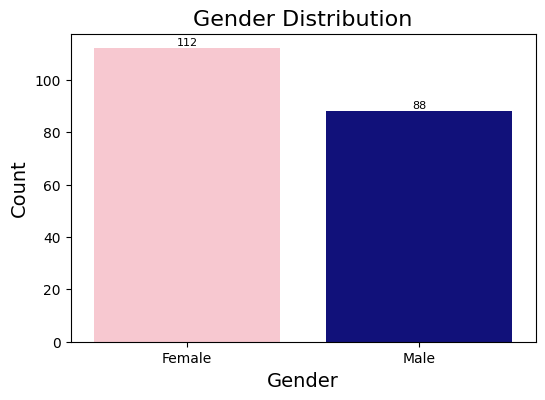

In [365]:
# count the values in 'Gender'
gender_counts = df['Gender'].value_counts()

# bar chart
plt.figure(figsize=(6, 4))
barplot = sns.barplot(
  x=gender_counts.index, 
  y=gender_counts.values, 
  palette=['pink', 'darkblue']
)

# data labels
for i, count in enumerate(gender_counts.values):
  plt.text(i, count + 1, str(count), ha='center', fontsize=8)

plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

### Bivariate Analysis: Correlation Heatmap

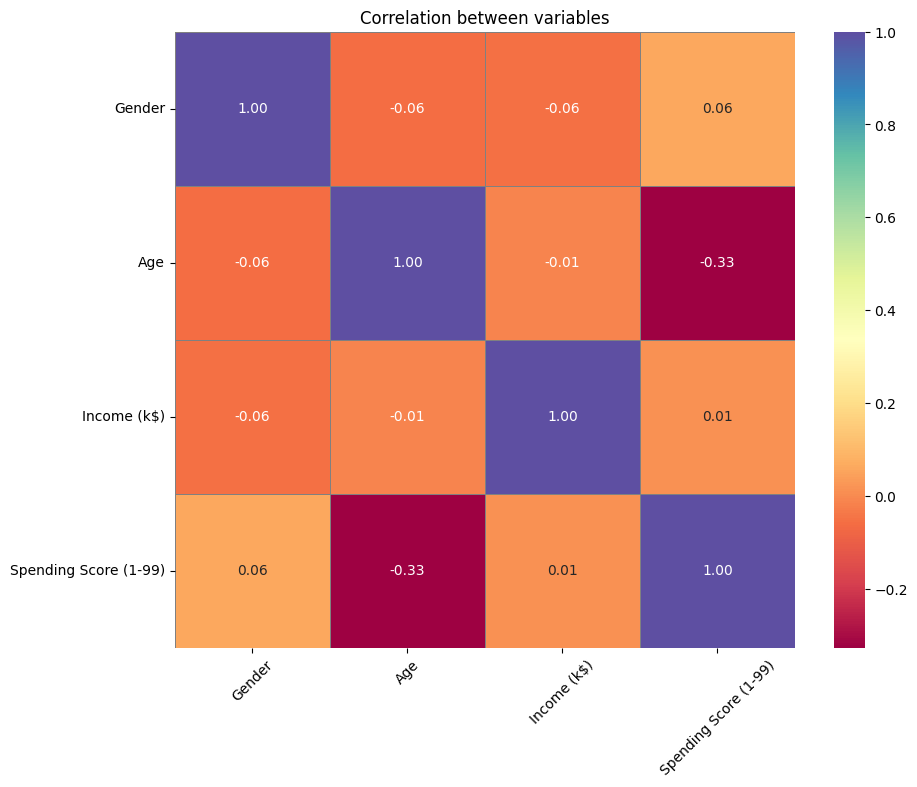

In [366]:
# temporarily encode categorical variable Gender
temp_df = df.copy()
temp_df['Gender'] = temp_df['Gender'].map({'Male': 0, 'Female': 1})

# get the correlation matrix for numerical columns only
correlation_matrix = temp_df.drop(columns=['CustomerID', 'Age Group']).corr()

# heatmap
plt.figure(figsize=(10, 8))                     
sns.heatmap(
  correlation_matrix, annot=True,      
  cmap='Spectral',                     
  fmt=".2f",                          
  linewidths=0.5, linecolor='gray')   
plt.title('Correlation between variables')         
plt.xticks(rotation=45)                          
plt.yticks(rotation=0)                           
plt.show()                     

* Age and Spending Score (1-99):
  * Negative correlation (-0.33), highlighted in red, suggests that older customers tend to spend less.

* Income and Spending Score (1-99):
  * Displays negligible correlation (0.01), represented in orange/yellow, indicating that income does not significantly influence spending patterns.

* Age and Income:
  * A weak negative correlation (-0.01) suggests no meaningful relationship between a customer's age and income level.

**Key Insights**
1. Age shows the strongest relationship with spending among the features, making it a valuable variable for customer segmentation.
2. Income and Spending Score (1-99) lack a meaningful correlation, implying income alone may not drive customer spending behaviour.
3. This analysis helps us identify which variables may be more significant when forming clusters, ensuring a focused and effective clustering approach.

### Bivariate Analysis: Pairplot

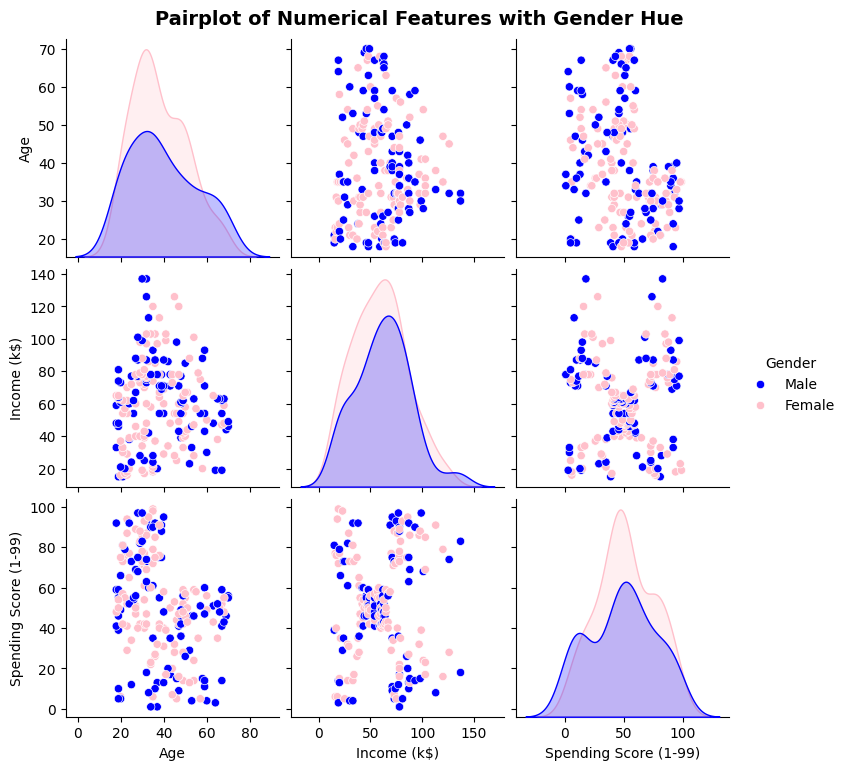

In [367]:
pairplot = sns.pairplot(
  df,
  vars=["Age", "Income (k$)", "Spending Score (1-99)"],
  hue="Gender", # hue to highlight gender differences
  diag_kind="kde",
  palette=['blue','pink'],
  height=2.5,
)

pairplot.fig.suptitle("Pairplot of Numerical Features with Gender Hue", y=1.02, fontsize=14, fontweight="bold")
plt.show()

**Interpretation:**
* Age Distribution (Top Left)
  * Both genders show similar age distributions, with most customers falling between 20-40 years old.
  * The distributions overlap substantially, indicating the store attracts similar age groups regardless of gender. The only noteworthy difference is the maximum age for females is much higher than that of males.

* Annual Income Distribution (Center)
  * Income distributions are similar for both genders, ranging from about $15k to $140k, with most customers earning between $50k-100k. This suggests income is independent of gender in this customer base.

* Spending Score Distribution (Bottom Right)
  * Spending scores range from 1-100. Females have higher spending scores than males on average, suggesting that females spend more than males.

* Age vs Annual Income (Row 2, Column 1)
  * The scatter plot shows no clear relationship between age and income. Customers across all age groups have varied income levels, distributed fairly randomly. Gender does not appear to influence this relationship.

* Age vs Spending Score (Row 3, Column 1)
  * There is no strong correlation between age and spending behavior. However, younger customers (under 40) show the full range of spending scores, while older customers (over 50) tend to cluster in the middle spending ranges.

* Annual Income vs Spending Score (Row 3, Column 2)
  * This is the most interesting relationship. The data suggests potential customer segments: high income with high spending, high income with low spending, low income with high spending, and low income with low spending. These visible clusters could be useful for targeted marketing strategies and shows that our data already contains natural clusters. KMeans is a potential algorithm.

**Business Implications:**
* For retail startups, this data suggests that **gender-based strategies may not be necessary** since spending patterns are similar across genders. Instead, **customer segments can be identified based on their income-spending relationship**.  
* The clusters visible in the income vs spending plot indicate distinct customer groups that likely require different marketing approaches and product offerings.

### Check Missing Values

In [368]:
df.isna().sum()

CustomerID               0
Gender                   0
Age                      0
Income (k$)              0
Spending Score (1-99)    0
Age Group                0
dtype: int64

* Dataset contains no missing data.  

* Investigated and resolved column `How Much They Spend` by renaming it to `Spending Score (1-99)`.  

* No irregularities found in remaining column data (e.g. entries containing negative `Income (k$)` or huge `Age` values).  

* Dataset is ready to be preprocessed!

---

## **STAGE 2: Data Preprocessing**
* **Remove ID Features**: Drop `CustomerID`
* **Remove Duplicates**: Drop duplicate rows
* **StandardScaler**: Scale features to prevent them from dominating euclidean distance-based algorithms like KMeans
* **One-Hot Encoding**: Encode categorical features

### Remove ID & Duplicates

In [369]:
df = df.drop_duplicates()
df = df.drop(columns=['CustomerID'])
print(f"Number of duplicate rows: {df.duplicated().sum()}")
print(f"Dropped CustomerID")

Number of duplicate rows: 0
Dropped CustomerID


### One-Hot Encoding `Gender`

In [370]:
encoder = OneHotEncoder(sparse_output=False, drop="first")
one_hot_gender = encoder.fit_transform(df[["Gender"]])

df = df.join(
  pd.DataFrame(one_hot_gender, columns=encoder.get_feature_names_out(["Gender"]))
).drop(columns="Gender")

df.head()

,Age,Income (k$),Spending Score (1-99),Age Group,Gender_Male
0,19,15,39,"(17, 25]",1.0
1,21,15,81,"(17, 25]",1.0
2,20,16,6,"(17, 25]",0.0
3,23,16,77,"(17, 25]",0.0
4,31,17,40,"(25, 35]",0.0


### StandardScaler
We scaled all our features using StandardScaler in our pipeline below (in STAGE 4 Employing Clustering Algorithms).

---

## **STAGE 3: Feature Engineering**
* **Create Relationship Features**: Create features that reflect behaviours or patterns, not raw values.
* **PCA (Principal Component Analysis)**: Reduce dimensionality and capture maximum variance in data

### `Spending-to-income` ratio

In [371]:
df["Spend_Income_Ratio"] = df["Spending Score (1-99)"] / df["Income (k$)"]
df.head()

,Age,Income (k$),Spending Score (1-99),Age Group,Gender_Male,Spend_Income_Ratio
0,19,15,39,"(17, 25]",1.0,2.600000
1,21,15,81,"(17, 25]",1.0,5.400000
2,20,16,6,"(17, 25]",0.0,0.375000
3,23,16,77,"(17, 25]",0.0,4.812500
4,31,17,40,"(25, 35]",0.0,2.352941


<Axes: xlabel='Spend_Income_Ratio', ylabel='Count'>

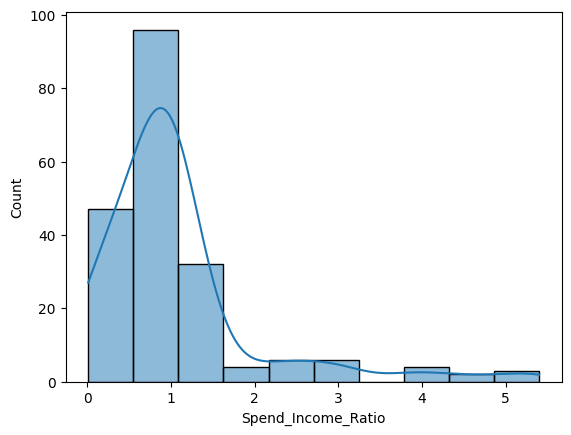

In [372]:
sns.histplot(df['Spend_Income_Ratio'], bins=10, kde=True)

---

## **STAGE 4: Employing Clustering Algorithms**

### Finalise Input Features
KMeans clustering works best when a small number of **meaningful** features are used.  
Including too many features can increase complexity and reduce the quality of the clusters formed. Therefore, features that do not contribute to clearer or more distinct clusters should be excluded.

#### Experiment: Include `Gender` or not?
* Use sklearn's Pipeline to streamline the model training process
* Exclude engineered features first, only include them later to ensure the clustering is actually due to Gender.

In [373]:
features_with_gender = [
  "Age",
  "Income (k$)",
  "Spending Score (1-99)",
  "Gender_Male"
]

##### KMeans without `Gender`

In [374]:
preprocess_no_gender = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features_with_gender[:-1]) # exclude the last element in the features list: Gender)
  ]
)

pipeline_no_gender = Pipeline(
  steps=[
    ("preprocess", preprocess_no_gender),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_No_Gender"] = pipeline_no_gender.fit_predict(df)

##### KMeans with `Gender`

In [375]:
preprocess_with_gender = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features_with_gender) # includes Gender
  ]
)

pipeline_with_gender = Pipeline(
  steps=[
    ("preprocess", preprocess_with_gender),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_With_Gender"] = pipeline_with_gender.fit_predict(df)

##### Compare Clustering

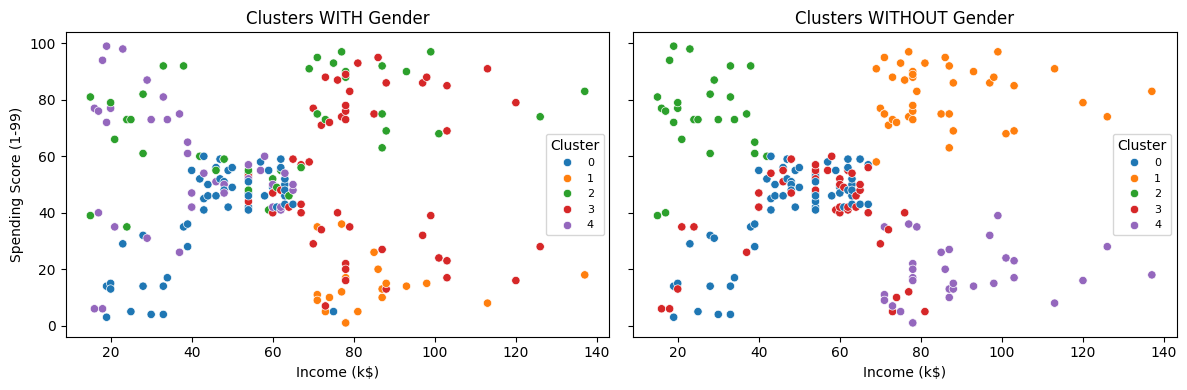

In [376]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# WITH Gender
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_With_Gender",
  palette="tab10",
  ax=axes[0]
)
axes[0].set_title("Clusters WITH Gender")
axes[0].legend(title="Cluster", fontsize=8)

# WITHOUT Gender
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_No_Gender",
  palette="tab10",
  ax=axes[1]
)
axes[1].set_title("Clusters WITHOUT Gender")
axes[1].legend(title="Cluster", fontsize=8)

plt.tight_layout()
plt.show()

# clean up df
df = df.drop(columns=["Cluster_No_Gender", "Cluster_With_Gender"])

#### Experiment: `Spend_Income_Ratio`
Is the engineered feature useful? Does it help clusters form more distinctly?

In [377]:
features_with_ratio = [
  "Age",
  "Income (k$)",
  "Spending Score (1-99)",
  "Spend_Income_Ratio"
]

##### KMeans without `Spend_Income_Ratio`

In [378]:
preprocess_no_ratio = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features_with_ratio[:-1])
  ]
)

pipeline_no_ratio = Pipeline(
  steps=[
    ("preprocess", preprocess_no_ratio),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_No_Ratio"] = pipeline_no_ratio.fit_predict(df)

##### KMeans with `Spend_Income_Ratio`

In [379]:
preprocess_with_ratio = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features_with_ratio)
  ]
)

pipeline_with_ratio = Pipeline(
  steps=[
    ("preprocess", preprocess_with_ratio),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_With_Ratio"] = pipeline_with_ratio.fit_predict(df)

#### Compare Clusters

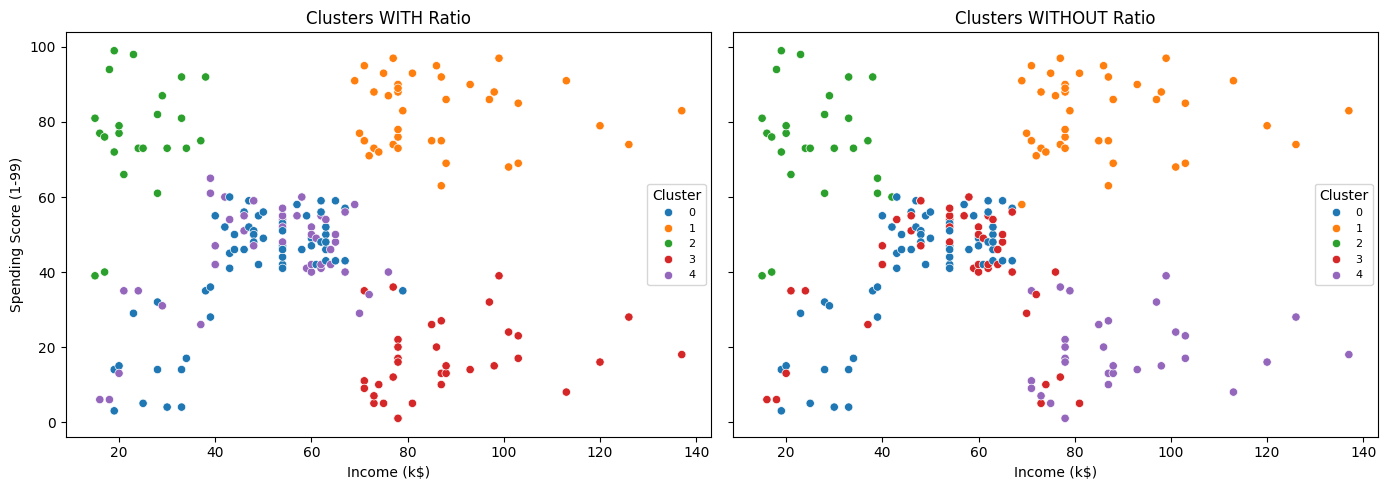

In [380]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# WITH ratio 
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_With_Ratio",
  palette="tab10",
  ax=axes[0]
)
axes[0].set_title("Clusters WITH Ratio")
axes[0].legend(title="Cluster", fontsize=8)

# WITHOUT Ratio
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_No_Ratio",
  palette="tab10",
  ax=axes[1]
)
axes[1].set_title("Clusters WITHOUT Ratio")
axes[1].legend(title="Cluster", fontsize=8)

plt.tight_layout()
plt.show()

# clean up df
df = df.drop(columns=["Cluster_No_Ratio", "Cluster_With_Ratio"])

`Spending_Income_Ratio` helped to resolve a small amount of mess/overlap in our clusters, though its impact on the clustering was not substantial. Keeping the feature would likely add noise which increases our model complexity, doing more harm than good.

### Compare Scaled VS Unscaled Data

In [381]:
features = [
  "Age",
  "Income (k$)",
  "Spending Score (1-99)",
  # concluded to exclude gender and spend_income_ratio
]

#### Raw/Unscaled Features
The preprocessing step in the previous pipelines on Gender and Ratio filtered out non-numeric features, preventing interval-type data from being passed into the KMeans algorithm.  
This pipeline has no preprocessor, so I have to manually pass in the features when fitting KMeans in pipeline.fit_predict().

In [382]:
pipeline_no_scale = Pipeline(
  steps=[
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_Unscaled"] = pipeline_no_scale.fit_predict(df[features])

# calculate silhouette score
X_unscaled = df[features].values
labels_unscaled = df["Cluster_Unscaled"]
silhouette_unscaled = silhouette_score(X_unscaled, labels_unscaled)

#### Scaled Features
The preprocessor drops all the columns not specified in the list features. Thus, I do not have to manually pass in the features when fitting KMeans in pipeline.fit_predict().

In [383]:
preprocess_with_scale = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), features)
  ]
)

pipeline_with_scale = Pipeline(
  steps=[
    ("preprocess", preprocess_with_scale),
    ("kmeans", KMeans(n_clusters=5, random_state=42))
  ]
)

df["Cluster_Scaled"] = pipeline_with_scale.fit_predict(df)

# calculate silhouette score
X_scaled = pipeline_with_scale.named_steps["preprocess"].transform(df)
labels_scaled = df["Cluster_Scaled"]
silhouette_scaled = silhouette_score(X_scaled, labels_scaled)

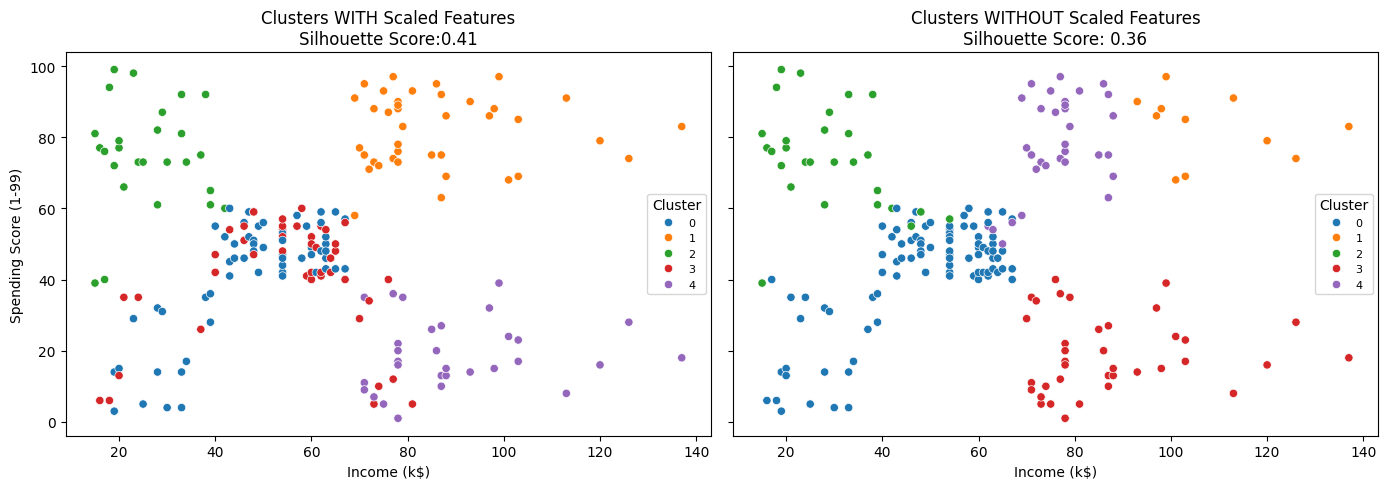

In [384]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# WITH scaling
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_Scaled",
  palette="tab10",
  ax=axes[0]
)
axes[0].set_title(f"Clusters WITH Scaled Features\nSilhouette Score:{silhouette_scaled:.2f}")
axes[0].legend(title="Cluster", fontsize=8)

# WITHOUT scaling
sns.scatterplot(
  data=df,
  x="Income (k$)",
  y="Spending Score (1-99)",
  hue="Cluster_Unscaled",
  palette="tab10",
  ax=axes[1]
)
axes[1].set_title(f"Clusters WITHOUT Scaled Features\nSilhouette Score: {silhouette_unscaled:.2f}")
axes[1].legend(title="Cluster", fontsize=8)

plt.tight_layout()
plt.show()

### Extract & Visualise Scaled Features

In [385]:
X_scaled = pipeline_with_scale.named_steps["preprocess"].transform(df[features])
feature_names = pipeline_with_scale.named_steps[
  "preprocess"
].get_feature_names_out()

clean_names = [name.replace("num__", "") for name in feature_names]

X_scaled_df = pd.DataFrame(X_scaled, columns=clean_names)
X_scaled_df = X_scaled_df.add_suffix("_scaled")
df = pd.concat([df, X_scaled_df], axis=1)

#### Normalised Distribution: mean 0, std 1

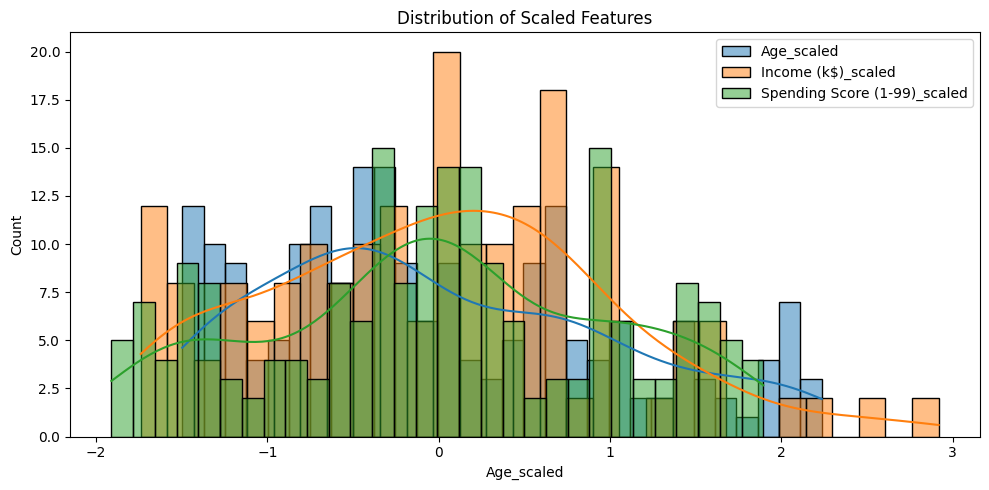

In [386]:
scaled_cols = [
  "Age_scaled",
  "Income (k$)_scaled",
  "Spending Score (1-99)_scaled"
]

plt.figure(figsize=(10, 5))
for col in scaled_cols:
  sns.histplot(df[col], kde=True, label=col, bins=30)

plt.title("Distribution of Scaled Features")
plt.legend()
plt.tight_layout()
plt.show()


In [387]:
df[scaled_cols].describe().loc[['mean', 'std']]

,Age_scaled,Income (k$)_scaled,Spending Score (1-99)_scaled
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00


### Find Optimal k-value

#### Elbow Method

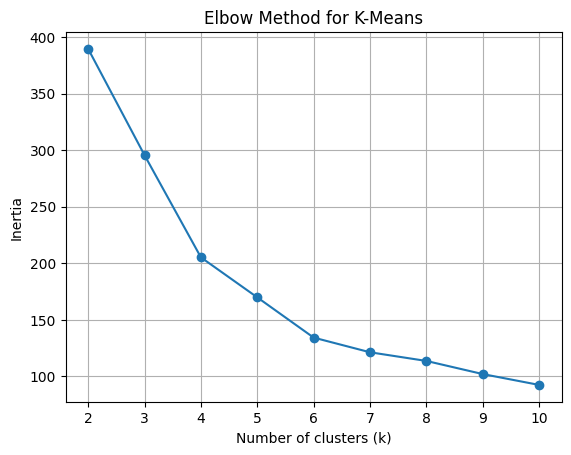

In [388]:
inertia = []

for k in range(2, 11):
  km = KMeans(n_clusters=k, random_state=42)
  km.fit(X_scaled)
  inertia.append(km.inertia_)

plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.grid(True)
plt.show()

#### Silhouette Score

![Silhouette Score Formula]("silhouette_score_formula.png")

a(i) = average distance to points in the same cluster  
b(i) = average distance to points in the nearest other cluster

In [389]:
k_range = range(2, 10)
sil_scores = {}

k=2, silhouette=0.335
k=3, silhouette=0.358
k=4, silhouette=0.404
k=5, silhouette=0.408
k=6, silhouette=0.431
k=7, silhouette=0.41
k=8, silhouette=0.367
k=9, silhouette=0.374


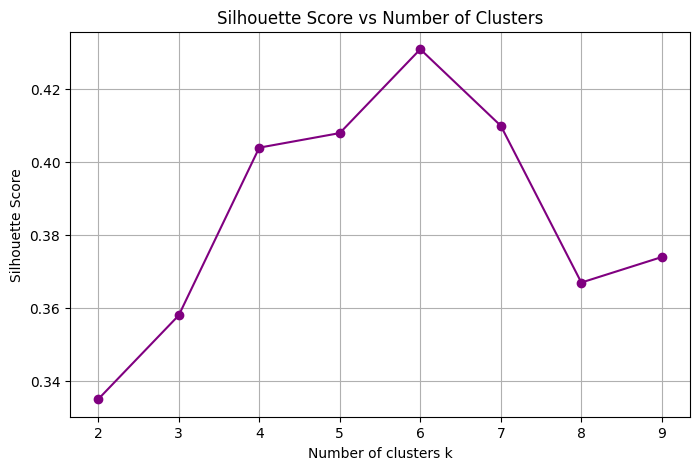

In [390]:
for k in k_range: # check sil scores for k=2 to k=9 
  km = KMeans(n_clusters=k, random_state=42)
  labels = km.fit_predict(X_scaled)
  score = silhouette_score(X_scaled, labels)
  sil_scores[k] = round(score, 3)
  print(f"k={k}, silhouette={sil_scores[k]}")

# plot silhouette scores vs k
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores.values(), marker='o', linestyle='-', color='purple')
plt.xticks(k_range)
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid(True)
plt.show()

#### Silhouette Plot
Measures cluster balance, distribution of silhouette values per cluster, overlap between clusters

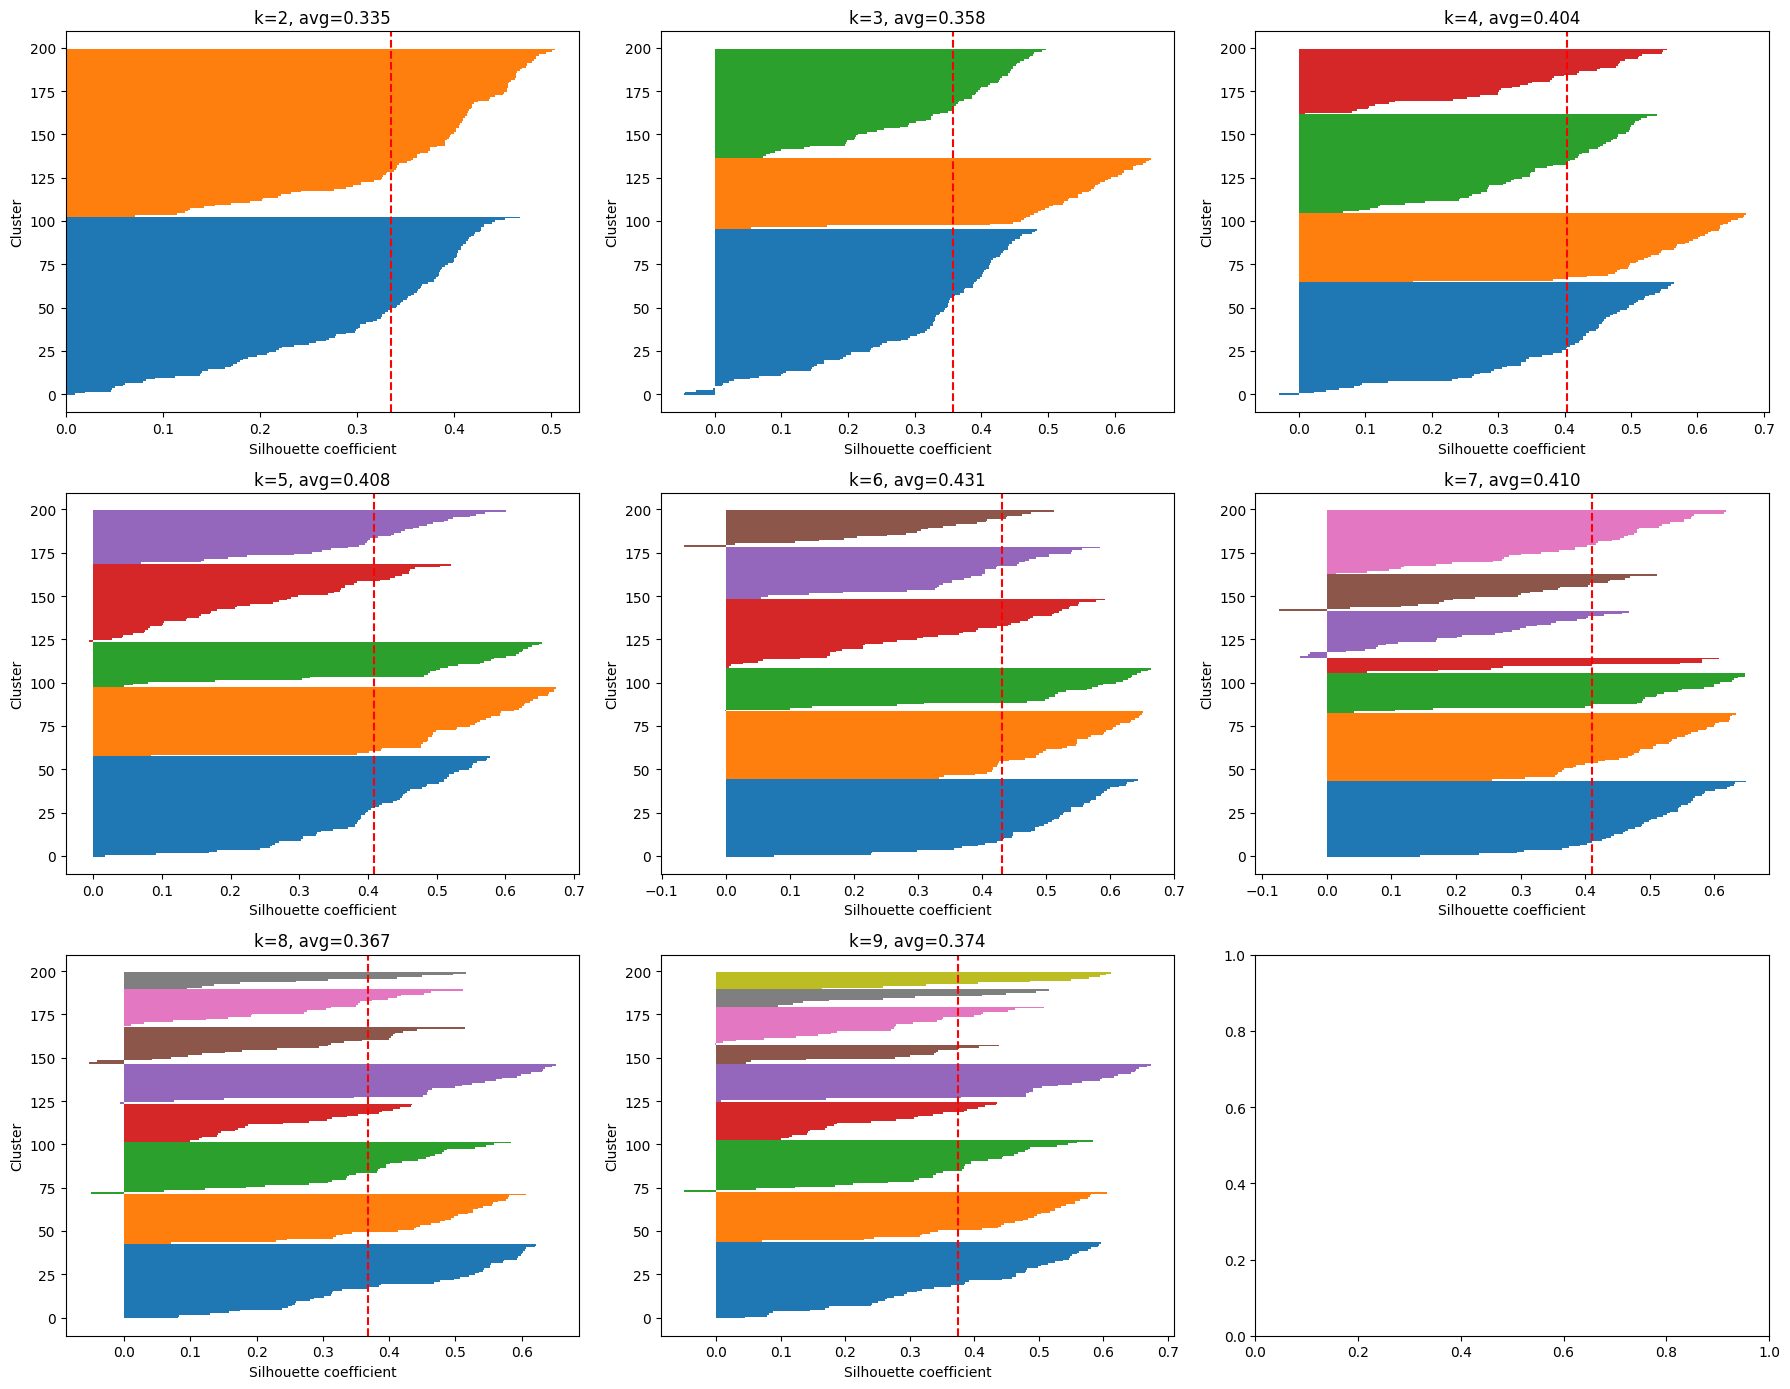

In [391]:
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for ax, k in zip(axes, k_range):
  km = KMeans(n_clusters=k, random_state=42)
  labels = km.fit_predict(X_scaled)
  
  silhouette_vals = silhouette_samples(X_scaled, labels)
  avg_score = silhouette_score(X_scaled, labels)
  
  y_lower = 0
  for i in range(k):
    cluster_vals = silhouette_vals[labels == i]
    cluster_vals.sort()
    y_upper = y_lower + len(cluster_vals)
    
    ax.barh(
      range(y_lower, y_upper),
      cluster_vals,
      height=1
    )
    y_lower = y_upper
  
  ax.axvline(avg_score, color="red", linestyle="--")
  ax.set_xlabel("Silhouette coefficient")
  ax.set_ylabel("Cluster")
  ax.set_title(f"k={k}, avg={avg_score:.3f}")

plt.tight_layout()
plt.show()

### Visualise Clusters with PCA (Principal Component Analysis)

In [392]:
pca = PCA(n_components=2) # instantiate PCA
X_pca = pca.fit_transform(X_scaled)

Subplot for k=2 completed.
Subplot for k=3 completed.
Subplot for k=4 completed.
Subplot for k=5 completed.
Subplot for k=6 completed.
Subplot for k=7 completed.
Subplot for k=8 completed.
Subplot for k=9 completed.


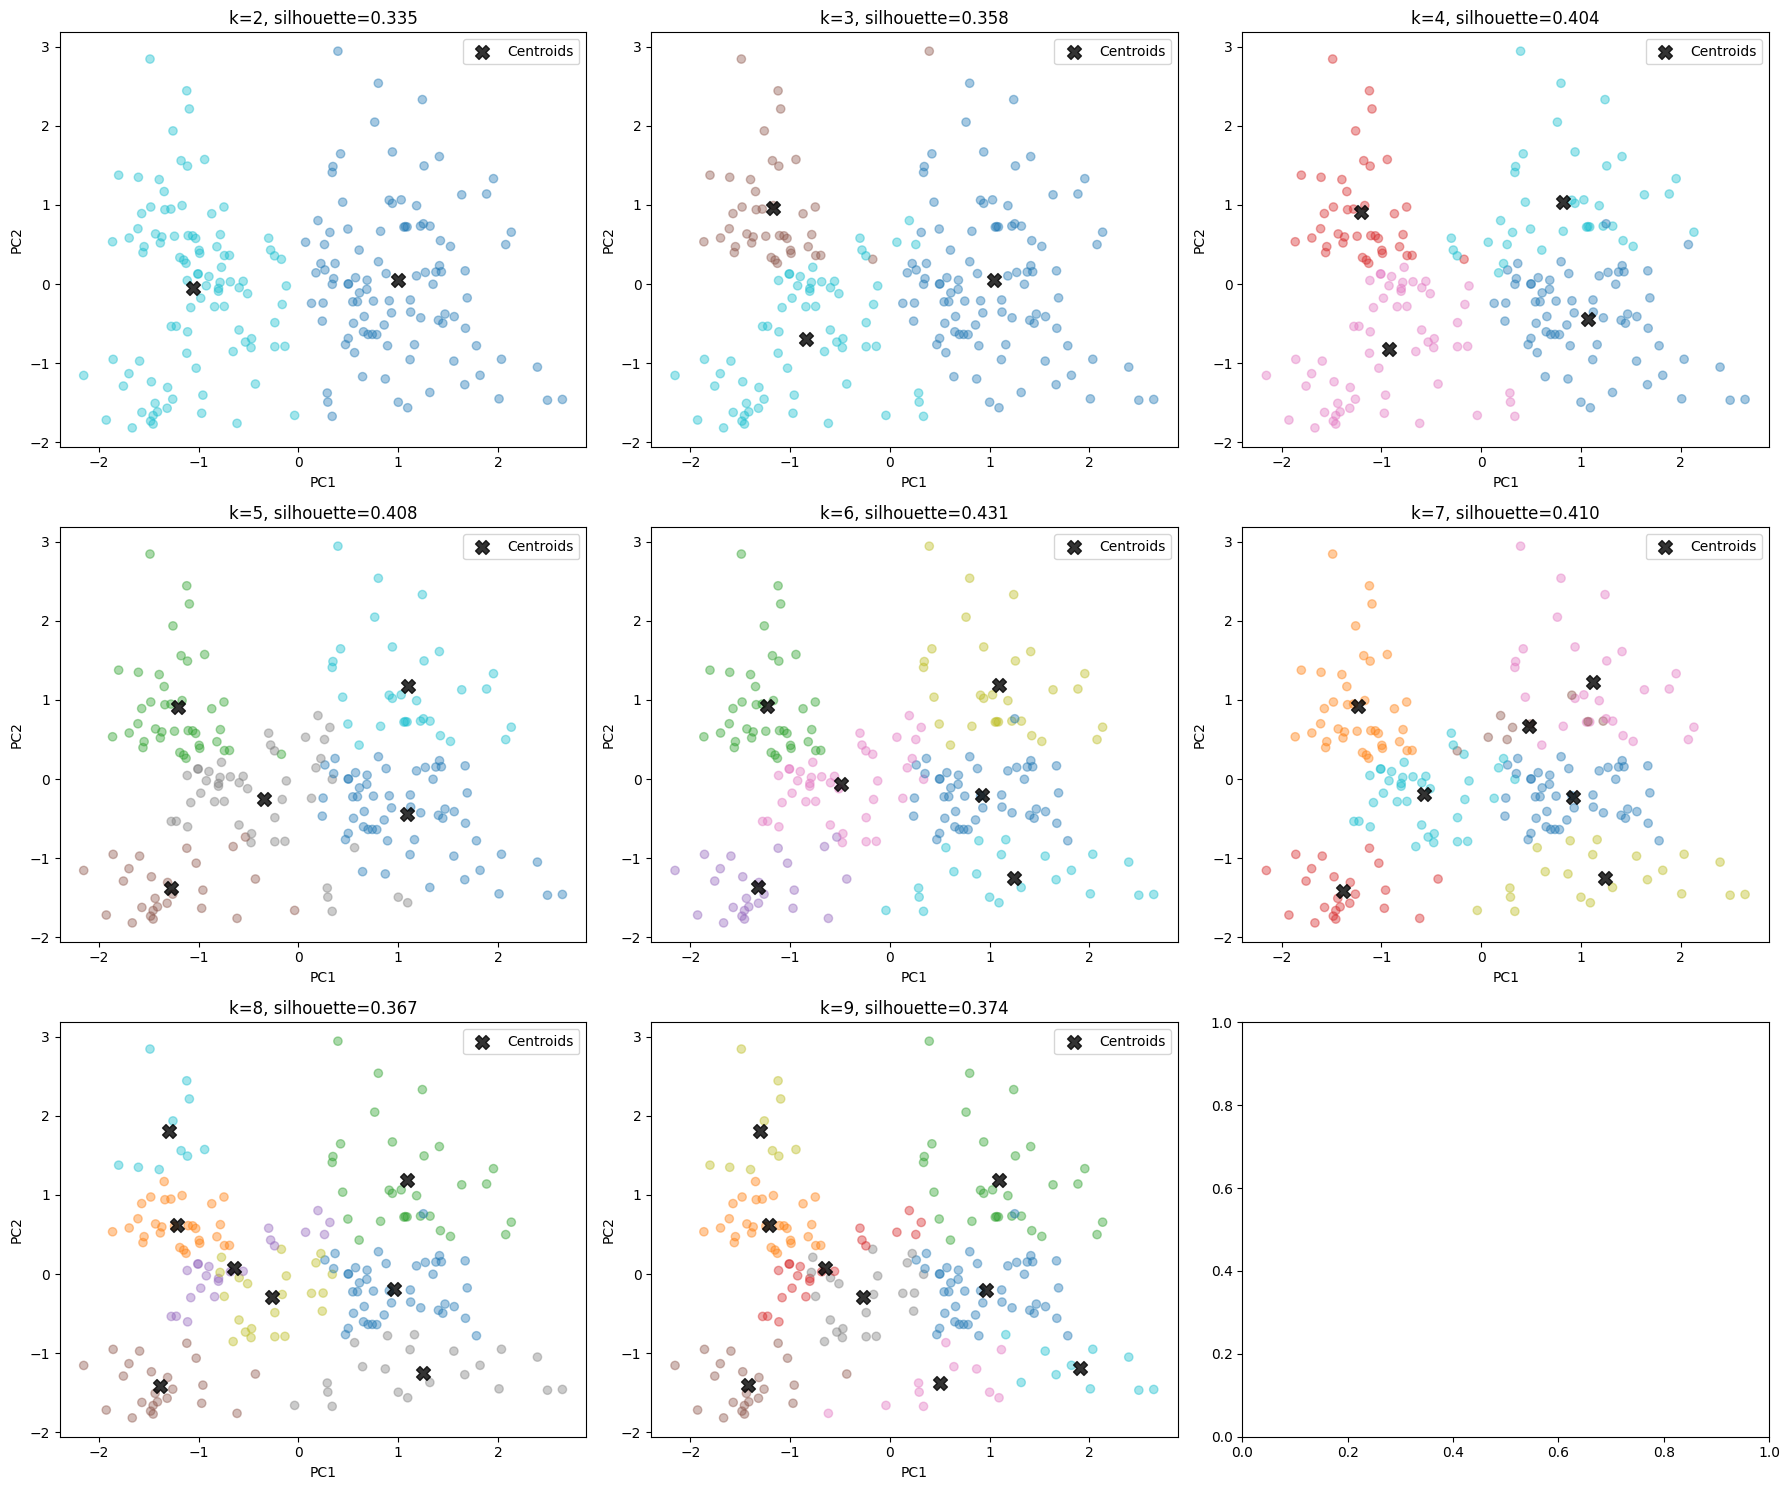

PCA achieved an explained variance ratio of  [0.44266167 0.33308378]


In [393]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15)) # 2rows x 3cols
axes = axes.flatten() # flatten for easy indexing

for idx, k in enumerate(k_range):
  kmeans = KMeans(n_clusters=k, random_state=42) # instantiate kmeans with respective n_clusters
  labels = kmeans.fit_predict(X_scaled)

  # project centroids into PCA space
  centroids_pca = pca.transform(kmeans.cluster_centers_)

  # generate scatter plot in corresponding subplot
  ax = axes[idx]

  # plot cluster points
  scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, alpha=0.4, cmap="tab10")

  # plot centroids
  ax.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c="black", s=100, marker="X", label="Centroids", alpha=0.8
  )
  ax.set_title(f"k={k}, silhouette={sil_scores[k]:.3f}")
  ax.set_xlabel("PC1")
  ax.set_ylabel("PC2")
  ax.legend()
  print(f"Subplot for k={k} completed.")

plt.tight_layout()
plt.show()

# generate silhouette score summary table
print("PCA achieved an explained variance ratio of ", pca.explained_variance_ratio_)

### Visualise Clusters with t-SNE
t-distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique for visualising high-dimensional data in 2D or 3D.  
It preserves local structure so points that are close in high dimensions remain close in the 2D or 3D plot, making clusters visually meaningful.  

#### How It Works:
* Computes pairwise similarities between points in high-dimensional space.
* Converts them into probabilities (how likely points are neighbours).
* Places points in low-dimensional space (e.g., 2D) such that these neighbour probabilities are preserved.
* Uses t-distribution in 2D to handle crowding (more spread for distant points, tighter for close points).
* Optimises via gradient descent to minimise the difference (KL divergence) between high- and low-dimensional distributions.  
💡 Analogy: Imagine a 3D ball of points — t-SNE “flattens” it onto paper while keeping close friends together.

#### Use k=6
Concluded as the most optimal k-value based on the silhouette score (highest at 0.431) and the elbow method.

In [394]:
df.head(1)

,Age,Income (k$),Spending Score (1-99),Age Group,Gender_Male,Spend_Income_Ratio,Cluster_Unscaled,Cluster_Scaled,Age_scaled,Income (k$)_scaled,Spending Score (1-99)_scaled
0,19,15,39,"(17, 25]",1.0,2.6,2,2,-1.424569,-1.738999,-0.434801


In [395]:
df = df.drop(columns=["Cluster_Unscaled", "Cluster_Scaled"])
df.head(1)

,Age,Income (k$),Spending Score (1-99),Age Group,Gender_Male,Spend_Income_Ratio,Age_scaled,Income (k$)_scaled,Spending Score (1-99)_scaled
0,19,15,39,"(17, 25]",1.0,2.6,-1.424569,-1.738999,-0.434801


In [396]:
kmeans = KMeans(n_clusters=6, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

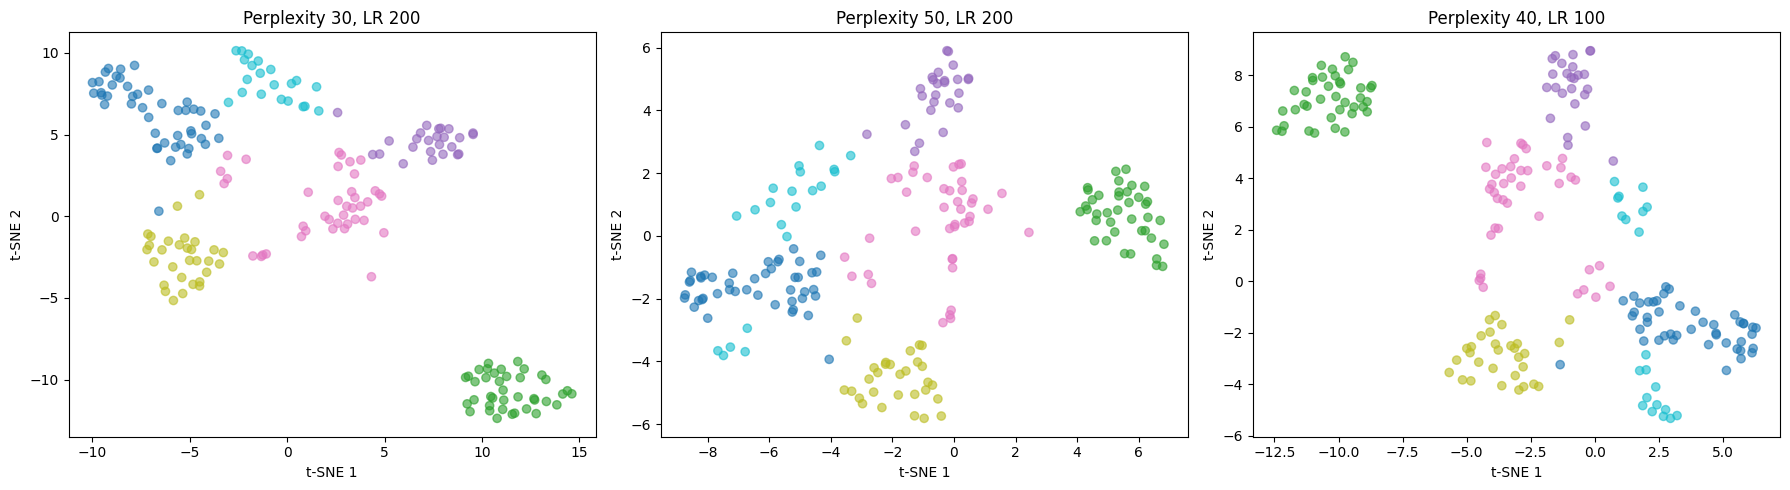

In [397]:
# list of t-SNE configs to compare
tsne_configs = [
  {"perplexity": 30, "learning_rate": 200, "title": "Perplexity 30, LR 200"},
  {"perplexity": 50, "learning_rate": 200, "title": "Perplexity 50, LR 200"},
  {"perplexity": 40, "learning_rate": 100, "title": "Perplexity 40, LR 100"},
]

plt.figure(figsize=(18, 5))

for i, cfg in enumerate(tsne_configs, 1):
  tsne = TSNE(
    n_components=2,
    perplexity=cfg["perplexity"],
    learning_rate=cfg["learning_rate"],
    random_state=42
  )
  X_tsne = tsne.fit_transform(X_scaled)
  
  plt.subplot(1, len(tsne_configs), i)
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["Cluster"], alpha=0.6, cmap="tab10")
  plt.title(cfg["title"])
  plt.xlabel("t-SNE 1")
  plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

Check by:
- Looking for plots where clusters are most clearly separated and compact.
- Avoiding plots where clusters overlap heavily or look scattered randomly.
- Check consistency: run t-SNE a few times (random_state fixed for reproducibility) — prefer the configuration where clusters consistently separate.

Perplexity 30, LR 200 shows the most distinct clustering and no overlap.

---

## **STAGE 5: Interpretation**

### Interpret Customer Segmentation
* Radar Chart

Note metrics:
* Mean `Age` is ~39  
* Mean `Income (k$)` is ~60.6k$  

In [398]:
cluster_means = df.groupby("Cluster")[features].mean()
cluster_means

,Age,Income (k$),Spending Score (1-99)
Cluster,,,
0,56.333333,54.266667,49.066667
1,32.692308,86.538462,82.128205
2,25.560000,26.480000,76.240000
3,26.125000,59.425000,44.450000
4,44.000000,90.133333,17.933333
5,45.523810,26.285714,19.380952


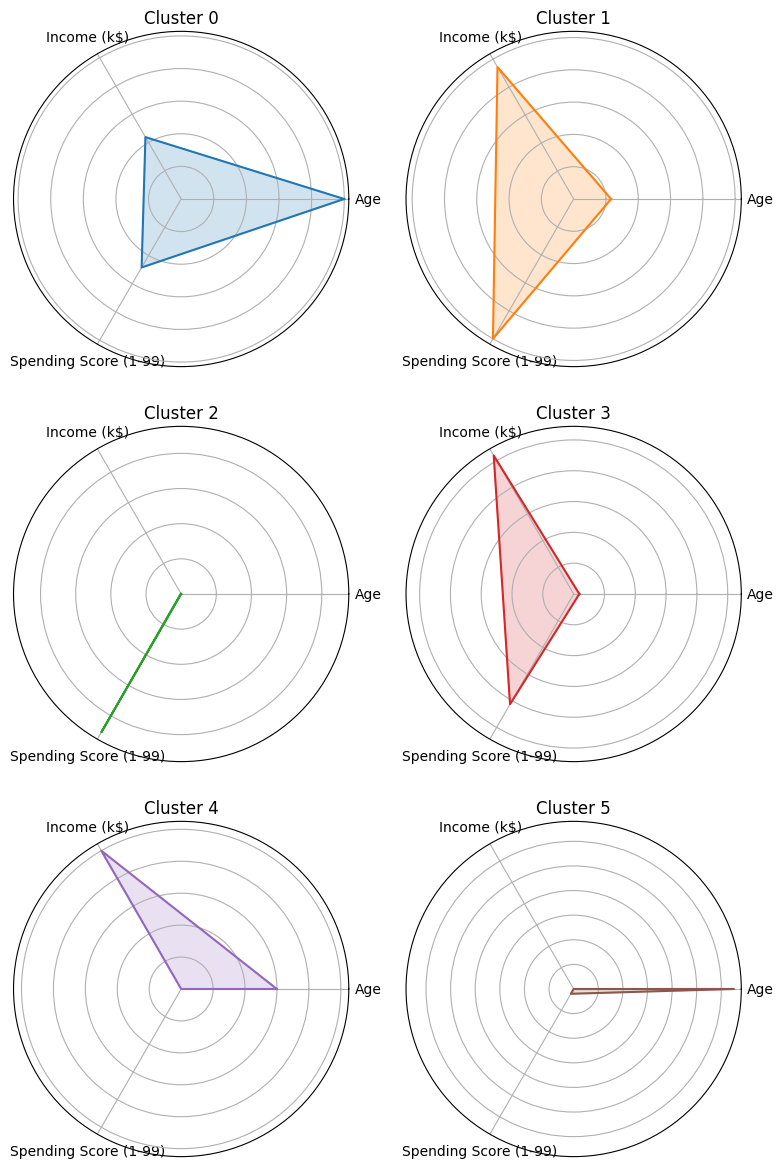

In [ ]:
# normalize features for radar chart (0-1 scale)
cluster_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

categories = list(cluster_norm.columns)
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1] # complete the loop

# setup subplots
num_clusters = cluster_norm.shape[0]
cols = 2
rows = (num_clusters + 1) // cols

plt.figure(figsize=(cols*4, rows*4))

for i, (cluster_id, row) in enumerate(cluster_norm.iterrows(), 1):
  values = row.tolist()
  values += values[:1] # complete the loop
  
  ax = plt.subplot(rows, cols, i, polar=True)
  ax.plot(angles, values, label=f"Cluster {cluster_id}", color=f"C{cluster_id}")
  ax.fill(angles, values, alpha=0.2, color=f"C{cluster_id}")
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(categories)
  ax.set_yticklabels([])
  ax.set_title(f"Cluster {cluster_id}", size=12)

plt.tight_layout()
plt.show()